<img src="../images/GeoCAT_logo.png" width=400 alt="GeoCAT Logo"></img>

# Advanced Matplotlib: Animation

---

## Learning Objectives
- Navigating GeoCAT-examples gallery
- Recreating an advanced matplotlib example with GeoCAT-examples
- Creating an animated plot

## Prerequisites


| Concepts | Importance |
| --- | --- |
| Basic familiarity with NumPy | Necessary |
| Basic familiarity with Matplotlib | Necessary |
| Basic familiarity with Cartopy | Helpful |
| Basic familiarity with Xarray | Helpful |

- **Time to learn**: *15-20 minutes*


---

In this notebook, we are going to roughly follow an example from GeoCAT-examples Gallery, [animate_1](https://geocat-examples.readthedocs.io/en/latest/gallery/Animations/NCL_animate_1.html), excluding the NCL formatting and documentation generation specific parts.

## Imports

In [1]:
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

In [ ]:
# geocat specific imports
import geocat.datafiles as gdf

## Get the data we want to animate
If you're replicating a script from geocat-examples, there's a good chance that we've stored the required data files in a repository called [geocat-datafiles](https://github.com/NCAR/geocat-datafiles), which we can pull from.

In [ ]:
# Open a netCDF data file using xarray default engine and load the data into xarrays
ds = xr.open_dataset(gdf.get("netcdf_files/meccatemp.cdf"), decode_times=False)

# Pull out surface tempterature Dataarray from xarray Dataset
tas = ds.t

In [ ]:
tas

<xarray.DataArray 't' (time: 31, lat: 40, lon: 49)>
array([[[273.15997, 273.15997, ..., 273.15997, 273.15997],
        [273.15997, 273.15997, ..., 273.15997, 273.15997],
        ...,
        [244.45306, 246.54042, ..., 248.61827, 244.45306],
        [250.04216, 250.22568, ..., 249.83124, 250.04216]],

       [[273.15997, 273.15997, ..., 273.15997, 273.15997],
        [273.15997, 273.15997, ..., 273.15997, 273.15997],
        ...,
        [235.51505, 236.63818, ..., 234.55936, 235.51505],
        [243.88503, 243.72353, ..., 244.17729, 243.88503]],

       ...,

       [[252.65335, 253.03725, ..., 252.30899, 252.65335],
        [261.95084, 263.23178, ..., 260.72147, 261.95084],
        ...,
        [248.28166, 244.65604, ..., 248.88187, 248.28166],
        [242.80939, 242.77512, ..., 242.7461 , 242.80939]],

       [[247.30048, 249.20201, ..., 246.48567, 247.30048],
        [258.08194, 260.4798 , ..., 254.9618 , 258.08194],
        ...,
        [235.83098, 234.93298, ..., 236.46327, 235.83098],
        [237.2076 , 237.15004, ..., 237.24037, 237.2076 ]]], dtype=float32)
Coordinates:
  * lat      (lat) int32 -86 -82 -77 -73 -68 -64 -59 ... 59 64 68 73 77 82 86
  * lon      (lon) int32 -180 -172 -165 -157 -150 -142 ... 150 157 165 172 180
  * time     (time) int32 1 2 3 4 5 6 7 8 9 10 ... 22 23 24 25 26 27 28 29 30 31
Attributes:
    units:    degrees

So, we have a latitude longitude grid over 31 time slices.

## Initial visualization
To get an idea about what we're working with, let's plot the first time slice and figure out how we want to fomat the plot before we get into the animation

Let's use xarray to plot the first time slice as a contour plot.

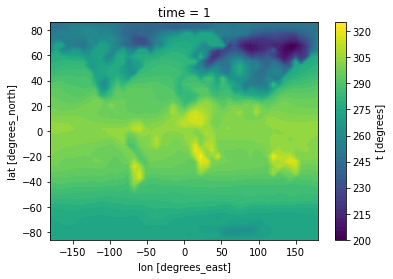

In [ ]:
tas[0,:,:].plot.contourf(levels=60)

Now, let's redo that, add some formatting to the plot. Here's a list of suggested changes that I'm going to implement in the next step:
- adding a projection and map overlay
- changing the axes and colorbar labels
- changing the colormap
- changing the size and positioning of the colorbar

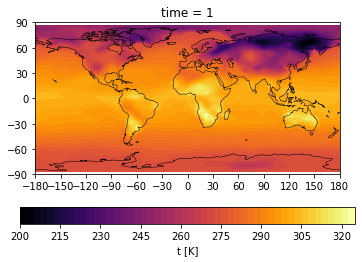

In [ ]:
fig = plt.figure()

# explicity set up axis with projection
ax = plt.axes(projection=ccrs.PlateCarree())

# add coastlines
ax.coastlines(linewidths=0.5)

tas[0, :, :].plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=60,
                           cmap="inferno",
                           cbar_kwargs={
                               "orientation": "horizontal",
                               "label": "t [K]"}
                            )

# configure axes
ax.set_xlabel("")
ax.set_xticks(np.arange(-180, 181, 30))

ax.set_ylabel("")
ax.set_yticks(np.arange(-90, 91, 30));

Now that we have somewhere to start, let's get in to the animation.

## Animation using matplotlib

We are going to be using matplotlib's [`FuncAnimation`](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html), which makes animations by repeatedly calling a function. Using this method involves three main steps:

1. Create an initial state of the plot
1. Make a function that can "progress" the plot to the next frame of the animation
1. Create the animation using `FuncAnimation`

See [matplotlib's animation documentation](https://matplotlib.org/stable/api/animation_api.html) for more information.

In [ ]:
from matplotlib.animation import FuncAnimation

### Step 1: Initial State

We're going to use the figure above as the step one "intial state" for the animation. An initilization function can be created separately and passed in as an argument to `FuncAnimation`, but it is optional.

### Step 2: Animation progression function
For each frame in the animation, we want to progress time index. The simplest way to achieve this is to make the progression function plot each time slice with the desired formatting.

Note that some of the formatting will have to be set after the plotting call, as the plotting call will override the user-specified formatting.

Also, if you are using a colorbar, it is important to establish the colorbar in the initilazation and set kwarg `add_colorbar` to be false. Otherwise, an additional colorbar will be added on each iteration.

In [ ]:
def update(i):
    tas[i, :, :].plot.contourf(ax=ax,
                       transform=ccrs.PlateCarree(),
                       levels=60,
                       cmap="inferno",
                       add_colorbar=False
                        )
    # configure axes
    
    ax.set_xlabel("")
    ax.set_xticks(np.arange(-180, 181, 30))

    ax.set_ylabel("")
    ax.set_yticks(np.arange(-90, 91, 30))
    
    # Set plot title
    ax.set_title("January Surface Temperatures (K) - Day " + str(i+1));

### Step 3: `FuncAnimation`
Now, we are going to create the animation. Note that when using `FuncAnimation`, it is important to save the output, even if you will never use it, as it is at risk of being collected by Python's garbage collector if not saved to an instance.

In [ ]:
# runs the animation
anim = FuncAnimation(fig, update, frames=31)

NameError: name 'fig' is not defined

To show the animation in this jupyter notebook, we need to set the html [rcParam](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.rc.html) for animation to `html5`, instead of the default, which is `none`.

In [ ]:
from matplotlib import rc
rc('animation', html='html5')
anim

Now, we can save the animation using `FuncAnimation.save()`. This step can take several minutes. We can also set a higher resolution with `dpi`.

In [ ]:
anim.save('animate.gif', writer='pillow', fps=5, dpi=300);

---

## Summary

- Matplotlib has animation plotting capabilities that are used by setting an initial plot and creating a "progression" function
- There are many different ways to display animations in jupyter notebooks
- Save created animations by using `FuncAnimation.save()`

## Resources and References
- [GeoCAT-examples Gallery](https://geocat-examples.readthedocs.io/en/latest/)
- [Matplotlib animation documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html)
